<font color='blue'> **27. Delay Interbed Drainage** </font> 

In [92]:
import os ; import pathlib as pl ; from pathlib import Path ; import flopy ; import matplotlib as mpl ; import os; import sys; 
import matplotlib.pyplot as plt ; import numpy as np ; from flopy.plot.styles import styles ; from modflow_devtools.misc import get_env 
sim_name = "ex-gwf-csub-p02" ; workspace = Path("./27") ; exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; import pandas as pd 
write = get_env("WRITE", True) ; run = get_env("RUN", True)  ; from flopy.utils.postprocessing import get_water_table 

In [ ]:
parameters = {"ex-gwf-csub-p02a": {"head_based": True ,"bed_thickness": (1.0,),                                   "kv": (2.5e-06,),"ndelaycells": 19},
              "ex-gwf-csub-p02b": {"head_based": False,"bed_thickness": (1.0,),                                   "kv": (2.5e-06,),"ndelaycells": 19},
              "ex-gwf-csub-p02c": {"head_based": True ,"bed_thickness": (1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0), "kv": 
                                   (2.5e-06, 1e-05, 6.25e-05, 0.00025, 0.001, 0.00625, 0.025)                                   ,"ndelaycells": 1001}}
length_units = "meters" ; time_units = "days" ; nlay = 1 ;ncol = 3 ;nrow = 1 ;delr = 1 ;delc = 1 ;top = 0 ;botm = -1000 ; strt = 0 ;icelltype = 0  
nper           = 1 ; tdis_ds = ((1000.0, 100, 1.05),)  
nouter = 1000 ; ninner = 300 ; hclose = 0.000000001 ; rclose = 0.000001 ; linaccel = "bicgstab" ; relax = 0.97  ; k11 = 1000000     # kv x k11 (m/d) 
sgm = 1.7  ;sgs = 2.0  ;tau0 = 1000.0  ;cg_theta = 0.2  ;ske = 1.0e-5  ;skv = 1.0e-2  ;theta= 0.45  ;h0= 1.0  ;head_offset = 1.0     ;c6 = []
for j in range(0, ncol, 2):     c6.append([0, 0, j, strt])

In [94]:
%%capture
def build_models(name ,subdir_name =".", head_based=True ,bed_thickness=1.0 ,kv=2e-6 ,ndelaycells=19,):
    if head_based:    hb_bool = True ; pc0 = head_offset  ; tsgm = None ; tsgs = None
    else:             hb_bool = None ; pc0 = -head_offset ; tsgm = sgm  ; tsgs = sgs
    sub6 = [[0 ,0 ,0 ,1 ,"delay" ,pc0 ,bed_thickness ,1.0 ,skv ,ske ,theta ,kv ,h0 ,"ib1"]]

    opth = f"{name}.csub.obs" ; csub_csv=opth+".csv"
    obs =  [("tcomp" ,"interbed-compaction" ,(0 ,)) ,("sk" ,"sk" ,(0 ,)) ,("qtop" ,"delay-flowtop" ,(0,)) ,("qbot" ,"delay-flowbot" ,(0,))]
    for k in range(ndelaycells): tag = f"H{k + 1:04d}" ; obs.append((tag, "delay-head", (0,), (k,)))
    if not head_based:
        iposm = int(ndelaycells / 2) + 1 ; iposb = ndelaycells - 1
        obs += [("est", "delay-estress", (0,), (0,))     ,("esm", "delay-estress", (0,)     , (iposm,)),
                ("esb", "delay-estress", (0,), (iposb,)) ,("gs", "gstress-cell", (0, 0, 1)) ,("es", "estress-cell", (0, 0, 1))]
    orecarray = {csub_csv: obs}   ; head_filerecord=f"{sim_name}.hds" ; budget_filerecord=f"{sim_name}.cbc"
    
    sim_ws = os.path.join(workspace, name)
    if subdir_name is not None: sim_ws = os.path.join(sim_ws, subdir_name)
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis   (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms    (sim,outer_maximum=nouter,outer_dvclose=hclose,linear_acceleration=linaccel,inner_maximum=ninner,inner_dvclose=hclose,
                             relaxation_factor=relax,rcloserecord=f"{rclose} strict") 
    gwf = flopy.mf6.ModflowGwf  (sim, modelname=name, save_flows=True, newtonoptions="newton")
    flopy.mf6.ModflowGwfdis (gwf ,length_units=length_units ,nlay=nlay ,nrow=nrow ,ncol=ncol ,delr=delr ,delc=delc ,top=top ,botm=botm)
    flopy.mf6.ModflowUtlobs (gwf ,digits=10 ,print_input=True ,continuous={"gwf_obs.csv":[("h1_1_2" ,"HEAD" ,(0 ,0 ,1))]})
    flopy.mf6.ModflowGwfic  (gwf ,strt=strt)
    flopy.mf6.ModflowGwfnpf (gwf ,icelltype=icelltype ,k=k11 ,save_specific_discharge=True ,)
    flopy.mf6.ModflowGwfsto (gwf ,iconvert=icelltype ,ss=0.0 ,sy=0 ,transient={0:True})
    csub = flopy.mf6.ModflowGwfcsub (gwf ,print_input=True ,save_flows=True ,head_based=hb_bool ,ndelaycells=ndelaycells ,boundnames=True ,ninterbeds=1, 
                                     sgm=tsgm ,sgs=tsgs ,cg_theta=cg_theta ,cg_ske_cr=0.0 ,beta=0.0 ,packagedata=sub6)  
    csub.obs.initialize(filename=opth, digits=10, print_input=True, continuous=orecarray)
    flopy.mf6.ModflowGwfchd (gwf, stress_period_data={0: c6})
    flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD","ALL"),("BUDGET","ALL")])
    return sim
def write_models(sim, silent=True): sim.write_simulation(silent=silent)
def run_models  (sim, silent=True): 
    success, buff = sim.run_simulation(silent=silent)  ;     assert success, buff
def scenarios(idx, silent=True):
    key = list(parameters.keys())[idx]   ; interbed_thickness = parameters[key]["bed_thickness"] 
    interbed_kv = parameters[key]["kv"]  ; params = parameters[key].copy()
    if len(interbed_thickness) == 1:
        params["bed_thickness"] = interbed_thickness[0]  ; params["kv"] = interbed_kv[0]
        sim = build_models(key, **params)
        if write: write_models(sim, silent=silent)
        if run:   run_models(sim, silent=silent)
    else:
        for b, kv in zip(interbed_thickness, interbed_kv):
            for head_based in (True, False):
                if head_based:     subdir_name = "hb-"
                else:              subdir_name = "es-"
                subdir_name += f"{int(b):03d}"  ; params["head_based"] = head_based ; params["bed_thickness"] = b ; params["kv"] = kv
                sim = build_models(key, subdir_name=subdir_name, **params)
                if write: write_models(sim, silent=silent)
                if run:   run_models(sim, silent=silent)
scenarios(0) ; scenarios(1); scenarios(2)

In [158]:
sim_ws = Path(workspace, list(parameters.keys())[0])   ; arrow_props = dict(facecolor="black", arrowstyle="-", lw=0.5)
ws = sim.simulation_data.mfpath.get_sim_path()         ; sim  = flopy.mf6.MFSimulation().load(sim_ws=ws, verbosity_level=0)
gwf = sim.get_model('ex-gwf-csub-p02a')                ; cobs = gwf.csub.output.obs().data             ; tpct = cobs["totim"] * 100 / tau0
gwf = sim.get_model(list(parameters.keys())[0])        ; head = gwf.output.head().get_data()           ; print('c6', c6)  ; wt=get_water_table(head)
print(tpct, 'tpct')

c6 [[0, 0, 0, 0], [0, 0, 2, 0]]
[3.83138070e-02 7.85433042e-02 1.20784276e-01 1.65137297e-01
 2.11707969e-01 2.60607174e-01 3.11951340e-01 3.65862714e-01
 4.22469657e-01 4.81906946e-01 5.44316101e-01 6.09845713e-01
 6.78651805e-01 7.50898203e-01 8.26756920e-01 9.06408573e-01
 9.90042808e-01 1.07785876e+00 1.17006550e+00 1.26688258e+00
 1.36854052e+00 1.47528135e+00 1.58735923e+00 1.70504099e+00
 1.82860685e+00 1.95835100e+00 2.09458236e+00 2.23762528e+00
 2.38782035e+00 2.54552518e+00 2.71111524e+00 2.88498481e+00
 3.06754786e+00 3.25923906e+00 3.46051482e+00 3.67185437e+00
 3.89376089e+00 4.12676274e+00 4.37141469e+00 4.62829923e+00
 4.89802800e+00 5.18124321e+00 5.47861917e+00 5.79086394e+00
 6.11872094e+00 6.46297080e+00 6.82443314e+00 7.20396861e+00
 7.60248084e+00 8.02091869e+00 8.46027844e+00 8.92160616e+00
 9.40600028e+00 9.91461410e+00 1.04486586e+01 1.10094053e+01
 1.15981894e+01 1.22164127e+01 1.28655471e+01 1.35471383e+01
 1.42628090e+01 1.50142633e+01 1.58032903e+01 1.66317

In [127]:
sys.path.append("E:/15_REPOS/00_BETAMI/bin/Flopy_functions")  
from Analitycal_SUB_01 import analytical_solution
name = 'ex-gwf-csub-p02a'      ; cc1 = []             ; nz = 100 ; thick = 1.0 ; 
kv = parameters[name]["kv"][0] ; dhalf = thick * 0.5  ; az = np.linspace(-dhalf, dhalf, num=nz)  ; dz = az[1] - az[0]
for tt in cobs["totim"]: 
    cc2 = 0.0
    for jdx, zz in enumerate(az): 
        f = 1.0
        if jdx == 0 or jdx == nz - 1:             f = 0.5
        h = analytical_solution(zz, tt, ssk=skv, vk=kv, n=200, dh=1.0) ;         cc2 += h * skv * f * dz
    cc1.append(cc2)
cc1 = np.array(cc1)


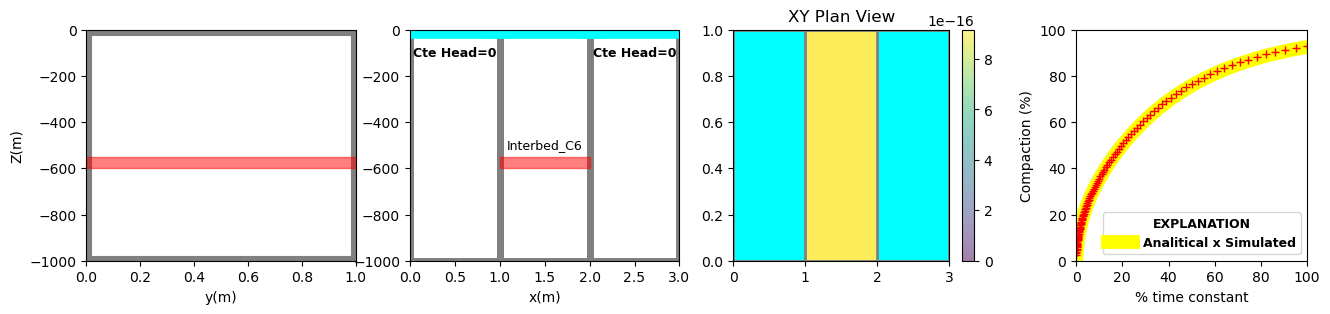

In [ ]:
fig = plt.figure(figsize=(16, 3))        
ax = fig.add_subplot(141) ; pxx = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"column": 0}) ; pxx.plot_grid(linewidth=8) ; ax.set_xlabel("y(m)")
ax.set_ylabel("Z(m)")     ; ax.fill_between([0 ,1] ,y1=-600 ,y2=-550 ,color="red" ,alpha=0.5)                

ax = fig.add_subplot(142) ; pxs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 0})    ; pxs.plot_grid(linewidth=5) ; ax.set_xlabel("x(m)")
styles.add_text(ax=ax ,text="Cte Head=0" ,x=0.5 ,y=-100 ,bold=True , italic=False ,transform=False ,va="center" ,ha="center" ,fontsize=9)
styles.add_text(ax=ax ,text="Cte Head=0" ,x=2.5 ,y=-100 ,bold=True , italic=False ,transform=False ,va="center" ,ha="center" ,fontsize=9)
styles.add_text(ax=ax ,text="Interbed_C6"   ,x=1.5 ,y=-500 ,bold=False , italic=False ,transform=False ,va="center" ,ha="center" ,fontsize=9)
ax.fill_between([1 ,2] ,y1=-600 ,y2=-550 ,color="red" ,alpha=0.5)   ; pxs.plot_surface(wt, masked_values=[1e30], color="cyan", lw=12) 

ax = fig.add_subplot(143)  ; pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0) ; ax.set_title('XY Plan View') 
pmv.plot_grid(linewidth=2) ; cb = pmv.plot_array(head, alpha=0.5) ; cb = plt.colorbar(cb) ; pmv.plot_bc("CHD", plotAll=True,color="cyan")

ax = fig.add_subplot(144, aspect="equal")              ; ax.plot(tpct,100 * cobs["TCOMP"] / skv,label="Analitical x Simulated",color="yellow", lw=10)
leg = styles.graph_legend(ax, loc="lower right")       ; ax.set_xlabel("% time constant")      ; ax.set_xlim(0, 100) ; ax.set_ylim(0, 100)                             ; ax.set_ylabel("Compaction (%)" )  
ax.plot(tpct,100 * cc1 / skv,marker="+",lw=0.05,ms=6,color="red" )                             ; plt.show() 

(-0.5, 944.5, 386.5, -0.5)

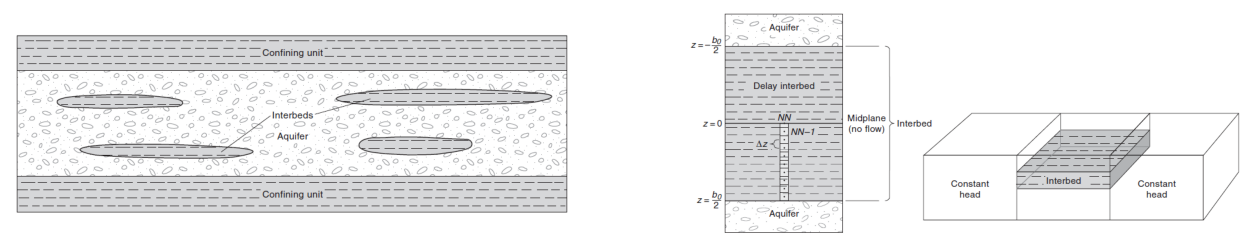

In [98]:
fig = plt.figure(figsize=(16, 12))                                                    
ax = fig.add_subplot(121,aspect="equal" ) ;image=plt.imread('E:/15_REPOS/00_BETAMI/bin/Flopy_3099/Fig/PDF_fig_27_SUB_2.PNG') ;ax.imshow(image) ;ax.axis('off')  
ax = fig.add_subplot(122,aspect="equal" ) ;image=plt.imread('E:/15_REPOS/00_BETAMI/bin/Flopy_3099/Fig/PDF_fig_27_SUB_1.PNG') ;ax.imshow(image) ;ax.axis('off')  

In [ ]:
import numpy as np

def analytical_solution(z, tt, dh=1.0, b0=1.0, ssk=100.0, vk=0.025, n=100, silent=True):
    vv = 0.0  ; ee = np.exp(1)  ; pi = np.pi ; pi2 = np.pi**2
    for k in range(n):
        fk = float(k) ; tauk = (0.5 * b0) ** 2.0 * ssk / ((2.0 * fk + 1.0) ** 2.0 * vk)
        ep = ((2.0 * fk + 1.0) ** 2 * pi2 * vk * tt) / (4.0 * ssk * (0.5 * b0) ** 2.0)
        rad = (2.0 * fk + 1.0) * pi * z / b0             ;  vv += ((-1.0) ** fk / (2.0 * fk + 1.0)) * (ee**-ep) * np.cos(rad)
        if not silent: print(f"{k:5d} {tauk:20g} {rad:20g} {vv:20g}")
    return dh - 4.0 * dh * vv / pi